# experimets variability

I want to have a visual of the variability of the experiments

# setup

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [80]:
FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

Let's first check that I have all the runs. 

## data

i create a link to where the data really is in a directory `data` parallel to the notebook

if things are moved away, make the link point to the right place

In [2]:
%pwd
%ls ../../data/results-report-rc2021/

'/home/jcasagrandebertoldo/repos/fcdd/python/analyse'

cifar10/                           fcdd_20211221161817_mvtec_/
fcdd_20211220193242_fmnist_/       fcdd_20211221161817_mvtec_.pt2/
fcdd_20211220193242_fmnist__AE/    fcdd_20211222095442_mvtec_/
fcdd_20211220193242_fmnist__HSC/   fcdd_20211223171505_mvtec_/
fcdd_20211220193450_fmnist_/       fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20211220193450_fmnist__AE/    fcdd_20220121004711_sup_pt3_mvtec_/
fcdd_20211220193450_fmnist__HSC/   fcdd_20220125103315_pascalvoc_/
fcdd_20211221161549_cifar10_/      fmnist/
fcdd_20211221161549_cifar10__AE/   mvtec/
fcdd_20211221161549_cifar10__HSC/


In [3]:
%mkdir -p data
%cd data
!ln -s ../../../data/results-report-rc2021 
%cd ..

/home/jcasagrandebertoldo/repos/fcdd/python/analyse/data
ln: failed to create symbolic link './results-report-rc2021': File exists
/home/jcasagrandebertoldo/repos/fcdd/python/analyse


In [4]:
%ls data/results-report-rc2021/

cifar10/                           fcdd_20211221161817_mvtec_/
fcdd_20211220193242_fmnist_/       fcdd_20211221161817_mvtec_.pt2/
fcdd_20211220193242_fmnist__AE/    fcdd_20211222095442_mvtec_/
fcdd_20211220193242_fmnist__HSC/   fcdd_20211223171505_mvtec_/
fcdd_20211220193450_fmnist_/       fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20211220193450_fmnist__AE/    fcdd_20220121004711_sup_pt3_mvtec_/
fcdd_20211220193450_fmnist__HSC/   fcdd_20220125103315_pascalvoc_/
fcdd_20211221161549_cifar10_/      fmnist/
fcdd_20211221161549_cifar10__AE/   mvtec/
fcdd_20211221161549_cifar10__HSC/


## funcs

In [5]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
from datetime import timedelta, datetime
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
import copy
from typing import List


# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}


def get_classes_labels_order(dataset: str) -> List[str]:
    return copy.deepcopy(CLASS_LABELS[dataset])


def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]


def get_training_time(path: Path) -> Dict[str, float]:
    """
    The is printed in `log.txt` as 
        START: 21-12-2021 22:46:18 
        DURATION: 1:13:29.009893 
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    
    # simple test
    TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0/log.txt")
    get_training_time(TEST_PATH)
    del TEST_PATH
    """
    DURATION_LINE_REGEX = r"^DURATION: (.+) $"
    DELTA_DATETIME_FORMAT = "%H:%M:%S.%f"
    
    # src: https://stackoverflow.com/a/1327389/9582881
    search = re.search(DURATION_LINE_REGEX, path.read_text(), re.MULTILINE)
    assert search is not None
    delta_str = search.group(1)
    assert delta_str != ""
    # src: https://stackoverflow.com/a/12352624/9582881
    t = datetime.strptime(delta_str, DELTA_DATETIME_FORMAT)
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    assert delta > timedelta(0)
    return {"training_timedelta": delta}


def get_roc(path: Path) -> Dict[str, Union[float, ndarray]]:
    """
    :param path: points to the 'roc.json' file inside an experiment (dataset + class + iteration)
    """
    ROC_JSON_EXPECTED_KEYS = {"tpr", "fpr", "ths", "auc"}
    ROC_JSON_LISTS = {"tpr", "fpr", "ths"}
    
    with path.open("r") as json_file:
        payload = json.load(json_file)
    
    assert type(payload) == dict, f"{type(payload)=}"
    assert set(payload.keys()) == ROC_JSON_EXPECTED_KEYS, f"{set(payload.keys())=}"
    
    # transform the lists in ndarrays
    for list_key in ROC_JSON_LISTS:
        list_obj = payload[list_key]
        assert type(list_obj) == list, f"{type(list_obj)=}"
        payload[list_key] = np.array(list_obj)
        
    return payload


def get_pixelwise_roc(path: Path) -> Dict[str, float]:
    """
    The pixel-wise roc is often lost in mvtec because the images are big so the json
    with all the tpr/fpr/ths would be too big (there's a limit of 10MB somewhere in the code)
    but the pixel-wise ROC-AUC is printed in `log.txt` as like
    ##### GTMAP ROC TEST SCORE 0.9562439079836628 #####
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    """
    # "gtmap" = "pixel-wise" here
    # i got the floating point pattern in stackoverflow
    # src: https://stackoverflow.com/a/12643073/9582881
    GTMAP_ROC_LINE_REGEX = r"##### GTMAP ROC TEST SCORE (([0-9]*[.])?[0-9]+) #####"
    
    # src: https://stackoverflow.com/a/1327389/9582881
    search = re.search(GTMAP_ROC_LINE_REGEX, path.read_text())
    assert search is not None
    val = float(search.group(1))
    assert 1 >= val >= 0
    return {"auc": val}


def experiment_key(experiment_dir: Path) -> str:
    """
    :param experiment_dir: path to the experiment directory
    """
    return f"{experiment_dir.parent.name}.{experiment_dir.name}"


def build_experiment_payload(experiment_dir: Path, dataset: str) -> Dict[str, Union[str, float, ndarray]]:
    """
    :param experiment_dir: path to the experiment directory
    """
    normal_class_str = experiment_dir.parent.name
    roc_json_path = experiment_dir / "roc.json"
    pixelwise_roc_pdf_path = experiment_dir / "gtmap_roc_curve.pdf"
    print_log_path = experiment_dir / "print.log"
    log_txt_path = experiment_dir / "log.txt"
    
    return {
        "normal_class": normal_class_str,
        "it": experiment_dir.name,
        "dir": experiment_dir,
        "roc_json_path": roc_json_path,
        "normal_class_label": get_class_label(normal_class_str, dataset),
        **get_training_time(log_txt_path),
        **{
            # this is a renaming so sample_roc/pixel_roc won't conflict
            f"sample_roc.{key}": val 
            for key, val in get_roc(roc_json_path).items()
        },
        **(
            {
                f"pixel_roc.{key}": val 
                for key, val in get_pixelwise_roc(print_log_path).items()
            }
            if pixelwise_roc_pdf_path.exists() else
            {}
        )
    }


def get_all_experiments_data(path: Path, dataset: str) -> Dict[str, Dict[str, Union[str, float, ndarray]]]:
    
    """
    :param path: a folder that looks like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    
    experiments = {
        (key := experiment_key(iterpath)): {
            **build_experiment_payload(iterpath, dataset=dataset),
            **{"key": key},
        }
        
        # first level: classes
        for dirpath in path.glob("normal_*")
        if dirpath.is_dir()
        
        # second level: iterations
        for iterpath in dirpath.glob("it_*")
        if iterpath.is_dir()
    }
    
    return experiments


# some simple tests
# TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0")
# build_experiment_payload(TEST_PATH, dataset="mvtec")
# del TEST_PATH

# TEST_PATH = Path("../../data/results/mvtec/supervised_merged/")
# all_dicts = get_all_rocs_experiment(TEST_PATH, dataset="mvtec")
# len(all_dicts)
# all_dicts[sorted(all_dicts)[0]]
# del TEST_PATH, all_dicts

# gather data

In [6]:
%ls data/results-report-rc2021/
%ls data/results-report-rc2021/cifar10/
%ls data/results-report-rc2021/mvtec/
%ls data/results-report-rc2021/fmnist/

cifar10/                           fcdd_20211221161817_mvtec_/
fcdd_20211220193242_fmnist_/       fcdd_20211221161817_mvtec_.pt2/
fcdd_20211220193242_fmnist__AE/    fcdd_20211222095442_mvtec_/
fcdd_20211220193242_fmnist__HSC/   fcdd_20211223171505_mvtec_/
fcdd_20211220193450_fmnist_/       fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20211220193450_fmnist__AE/    fcdd_20220121004711_sup_pt3_mvtec_/
fcdd_20211220193450_fmnist__HSC/   fcdd_20220125103315_pascalvoc_/
fcdd_20211221161549_cifar10_/      fmnist/
fcdd_20211221161549_cifar10__AE/   mvtec/
fcdd_20211221161549_cifar10__HSC/
fcdd_20211221161549_cifar10_@     fcdd_20211221161549_cifar10__HSC@
fcdd_20211221161549_cifar10__AE@
incomplete/  supervised_merged/  unsupervised_merged/
OE-CIFAR100/  OE-EMNIST/


In [7]:
%ls .

001-fmnist-compare.ipynb          005-memory-usage.ipynb
002-cifar-10-compare.ipynb        006-experiments-variability.ipynb
003-mvtec-compare.ipynb           data/
004-cifar-10-training-time.ipynb  fcdd-memory-usage@
004-fmnist-training-time.ipynb    pape-table2-mvtec-perf.txt


In [8]:
DF_FPATH = Path("data") / "006-experiments-variability.df.json"
DF_INDEXNAMES_FPATH = DF_FPATH.parent / f"{DF_FPATH.stem}.index-names.json"

In [9]:
import pandas as pd

try:
    print("loading df")
    # pandas cannot reload multindex properly
    # src: https://stackoverflow.com/a/55474405/9582881
    df = pd.read_json(DF_FPATH).set_index(pd.read_json(DF_INDEXNAMES_FPATH)[0].values.tolist())    
    
except:
    print("couldn't find df, recomputing")
    # variable
    records = {

        # ssup = semi-supervised
        "mvtec-ssup": get_all_experiments_data(
            path=Path("data/results-report-rc2021/mvtec/supervised_merged"), 
            dataset="mvtec"
        ),

        # unsup = unsupervised
        "mvtec-unsup": get_all_experiments_data(
            path=Path("data/results-report-rc2021/mvtec/unsupervised_merged"), 
            dataset="mvtec"
        ),

        "fmnist": get_all_experiments_data(
            path=Path("data/results-report-rc2021/fmnist/OE-CIFAR100/fcdd_20211220193450_fmnist_"), 
            dataset="fmnist"
        ),

        "cifar10": get_all_experiments_data(
            path=Path("data/results-report-rc2021/cifar10/fcdd_20211221161549_cifar10_"), 
            dataset="cifar10"
        ),
    }

    # df = DataFrame
    drop_columns = ["dir", "roc_json_path", "normal_class"]
    dfs = {
        experiment: pd.DataFrame.from_records(data=rec).T \
                        .drop(columns=drop_columns) \
                        .reset_index() \
                        .drop(columns=["index", "key"]) #\
                        .set_index(["normal_class_label", "it"])
        for experiment, rec in records.items()
    }

    exp_keys = sorted(dfs)

    df = pd.concat(
        objs=[dfs[k] for k in exp_keys],
        axis=0,
        keys=exp_keys,
    )
    df.index = df.index.rename(names="experiment", level=0)
    
    print("saving df")
    # pandas cannot reload multindex properly
    # src: https://stackoverflow.com/a/55474405/9582881
    pd.DataFrame(df.index.names).to_json(DF_INDEXNAMES_FPATH)
    df.reset_index().to_json(DF_FPATH)

df.head()

loading df


training_timedelta  \
experiment normal_class_label it                         
cifar10    airplane           it_0             1730000   
                              it_1             1798000   
                              it_2             2090000   
                              it_3             2309000   
                              it_4             2331000   

                                                                       sample_roc.tpr  \
experiment normal_class_label it                                                        
cifar10    airplane           it_0  [0.0, 0.00011111110000000001, 0.1122222222, 0....   
                              it_1  [0.0, 0.00011111110000000001, 0.1426666667, 0....   
                              it_2  [0.0, 0.00011111110000000001, 0.2076666667, 0....   
                              it_3  [0.0, 0.00011111110000000001, 0.2271111111, 0....   
                              it_4  [0.0, 0.00011111110000000001, 0.1496666667, 0....   

                                                                       sample_roc.fpr  \
experiment normal_class_label it                                                        
cifar10    airplane           it_0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.002,...   
                              it_1  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   
                              it_2  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   
                              it_3  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   
                              it_4  [0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....   

                                                                       sample_roc.ths  \
experiment normal_class_label it                                                        
cifar10    airplane           it_0  [51.8181838989, 50.8181838989, 16.0511569977, ...   
                              it_1  [60.8550758362, 59.8550758362, 14.4678506851, ...   
                              it_2  [62.5905227661, 61.5905227661, 12.3422994614, ...   
                              it_3  [53.1703681946, 52.1703681946, 11.7287960052, ...   
                              it_4  [51.9921722412, 50.9921722412, 14.3329000473, ...   

                                    sample_roc.auc  pixel_roc.auc  
experiment normal_class_label it                                   
cifar10    airplane           it_0        0.948551            NaN  
                              it_1        0.945596            NaN  
                              it_2        0.947252            NaN  
                              it_3        0.949191            NaN  
                              it_4        0.948097            NaN

## basic checks

- number of classes
- number of iterations


In [10]:
df.reset_index()[df.index.names].describe()

,experiment,normal_class_label,it
count,250,250,250
unique,4,35,5
top,mvtec-ssup,screw,it_0
freq,75,10,50


In [11]:
df.reset_index().groupby("experiment")[df.index.names[1:]].describe()

normal_class_label                             it               \
                         count unique          top freq count unique   top   
experiment                                                                   
cifar10                     50     10     airplane    5    50      5  it_0   
fmnist                      50     10  t-shirt/top    5    50      5  it_0   
mvtec-ssup                  75     15       bottle    5    75      5  it_0   
mvtec-unsup                 75     15       bottle    5    75      5  it_0   

                  
            freq  
experiment        
cifar10       10  
fmnist        10  
mvtec-ssup    15  
mvtec-unsup   15

In [12]:
df.reset_index().groupby(["experiment", "normal_class_label"])[df.index.names[2:]].describe()

it                  
                               count unique   top freq
experiment  normal_class_label                        
cifar10     airplane               5      5  it_0    1
            automobile             5      5  it_0    1
            bird                   5      5  it_0    1
            cat                    5      5  it_0    1
            deer                   5      5  it_0    1
            dog                    5      5  it_0    1
            frog                   5      5  it_0    1
            horse                  5      5  it_0    1
            ship                   5      5  it_0    1
            truck                  5      5  it_0    1
fmnist      ankle boot             5      5  it_0    1
            bag                    5      5  it_0    1
            coat                   5      5  it_0    1
            dress                  5      5  it_0    1
            pullover               5      5  it_0    1
            sandal                 5      5  it_0    1
            shirt                  5      5  it_0    1
            sneaker                5      5  it_0    1
            t-shirt/top            5      5  it_0    1
            trouser                5      5  it_0    1
mvtec-ssup  bottle                 5      5  it_0    1
            cable                  5      5  it_0    1
            capsule                5      5  it_0    1
            carpet                 5      5  it_0    1
            grid                   5      5  it_0    1
            hazelnut               5      5  it_0    1
            leather                5      5  it_0    1
            metal_nut              5      5  it_0    1
            pill                   5      5  it_0    1
            screw                  5      5  it_0    1
            tile                   5      5  it_0    1
            toothbrush             5      5  it_0    1
            transistor             5      5  it_0    1
            wood                   5      5  it_0    1
            zipper                 5      5  it_0    1
mvtec-unsup bottle                 5      5  it_0    1
            cable                  5      5  it_0    1
            capsule                5      5  it_0    1
            carpet                 5      5  it_0    1
            grid                   5      5  it_0    1
            hazelnut               5      5  it_0    1
            leather                5      5  it_0    1
            metal_nut              5      5  it_0    1
            pill                   5      5  it_0    1
            screw                  5      5  it_0    1
            tile                   5      5  it_0    1
            toothbrush             5      5  it_0    1
            transistor             5      5  it_0    1
            wood                   5      5  it_0    1
            zipper                 5      5  it_0    1

# mvtec

In [13]:
df.columns

Index(['training_timedelta', 'sample_roc.tpr', 'sample_roc.fpr',
       'sample_roc.ths', 'sample_roc.auc', 'pixel_roc.auc'],
      dtype='object')

In [14]:
mvtec_df = df.loc[["mvtec-ssup", "mvtec-unsup"]] \
            .drop(columns=['training_timedelta', 'sample_roc.tpr', 'sample_roc.fpr', 'sample_roc.ths'])

<AxesSubplot:xlabel='pixel_roc.auc', ylabel='normal_class_label'>

<AxesSubplot:xlabel='pixel_roc.auc', ylabel='normal_class_label'>

<AxesSubplot:xlabel='pixel_roc.auc', ylabel='normal_class_label'>

<AxesSubplot:xlabel='pixel_roc.auc', ylabel='normal_class_label'>

<AxesSubplot:xlabel='pixel_roc.auc', ylabel='normal_class_label'>

<AxesSubplot:xlabel='pixel_roc.auc', ylabel='normal_class_label'>

[Text(0, 0, 'Bottle'),
 Text(0, 1, 'Cable'),
 Text(0, 2, 'Capsule'),
 Text(0, 3, 'Carpet'),
 Text(0, 4, 'Grid')]

[Text(0, 0, 'Hazelnut'),
 Text(0, 1, 'Leather'),
 Text(0, 2, 'Metal nut'),
 Text(0, 3, 'Pill'),
 Text(0, 4, 'Screw')]

[Text(0, 0, 'Tile'),
 Text(0, 1, 'Toothbrush'),
 Text(0, 2, 'Transistor'),
 Text(0, 3, 'Wood'),
 Text(0, 4, 'Zipper')]

(80.0, 100.0)

(80.0, 100.0)

(80.0, 100.0)

Text(0, 0.5, 'Class')

Text(0, 0.5, '')

Text(0, 0.5, '')

Text(0.5, 0, 'Pixel-wise test ROC-AUC (%)')

Text(0.5, 0, 'Pixel-wise test ROC-AUC (%)')

Text(0.5, 0, 'Pixel-wise test ROC-AUC (%)')

Text(0.5, 0.98, 'Experiments on MVTec-AD: unsupervised V.S. semi-supervised')

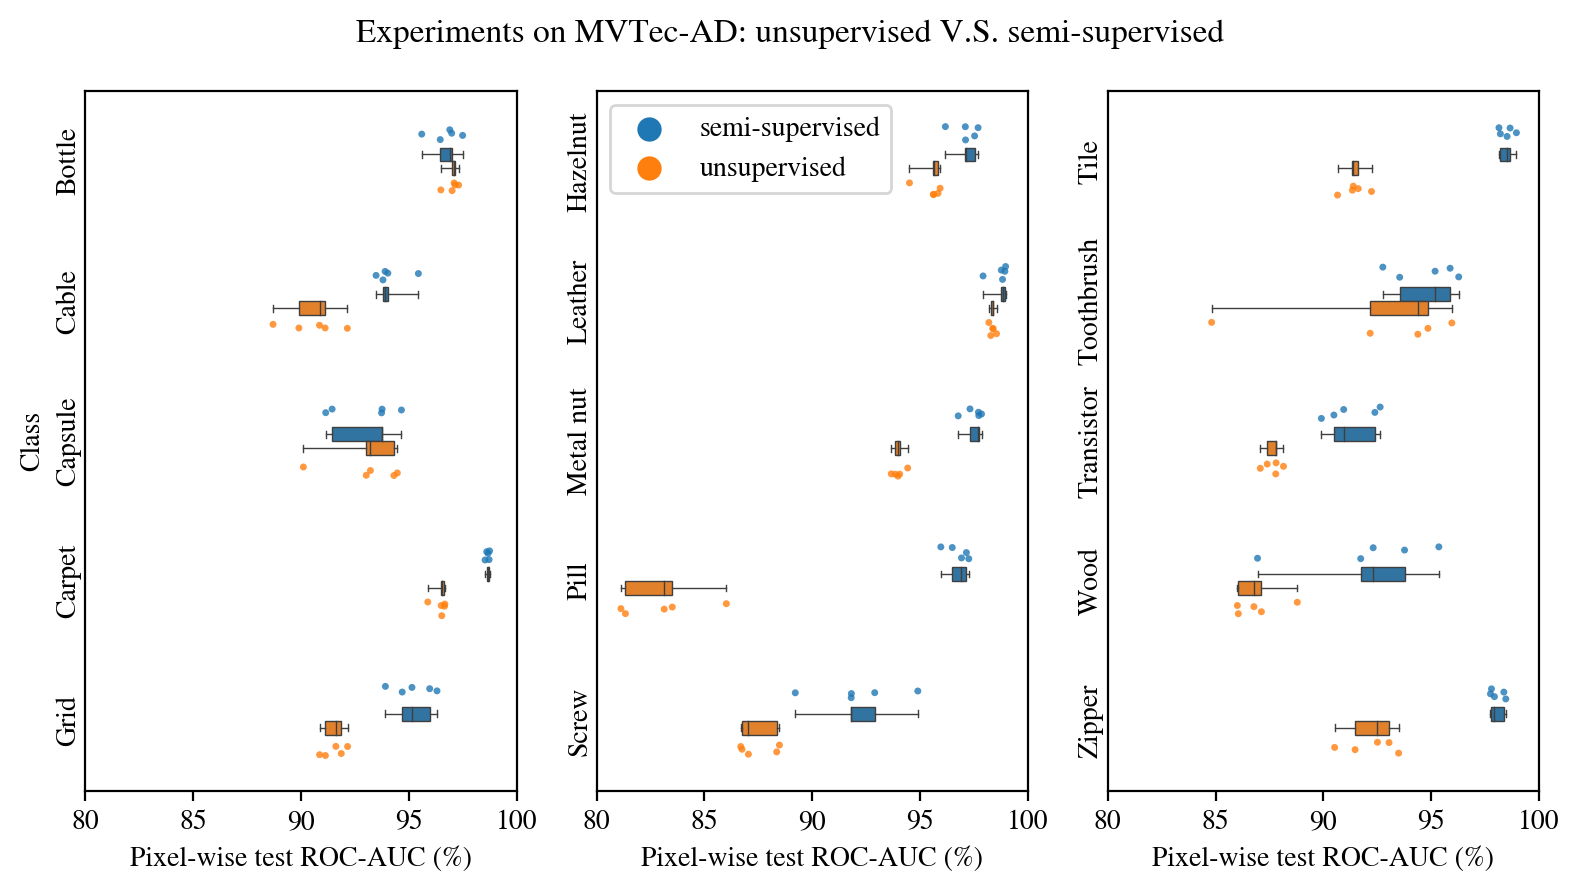

In [102]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

# latex-ish fonts
# src: https://stackoverflow.com/a/27697390/9582881
import matplotlib
# math
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# regular text
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

f, axs = plt.subplots(1, 3, figsize=(8, 4.5), dpi=200)

classes = get_classes_labels_order("mvtec")

def format_class_label(t):
    return t.replace("_", " ").capitalize()

plots = [
    {"ax": axs[0], "classes": classes[0:5], },
    {"ax": axs[1], "classes": classes[5:10], },
    {"ax": axs[2], "classes": classes[10:15], },
]

for plot in plots:

    ax = plot["ax"]
    classes = plot["classes"]
    df = mvtec_df.reset_index().set_index("normal_class_label").loc[classes].reset_index()

    # make it in %
    df["pixel_roc.auc"] = 100 * df["pixel_roc.auc"] 

    sns.boxplot(
        data=df, 
        ax=ax,
        x="pixel_roc.auc", 
        y="normal_class_label", 
        hue="experiment",
        # Otherwise, the points for each experiment will be plotted on top of each other.
        dodge=True,
        # whis=[0, 100],
        whis=[0, 100],
        width=.2,
        fliersize=20,
        linewidth=.5,
    )

    sns.stripplot(
        data=df, 
        ax=ax,
        x="pixel_roc.auc", 
        y="normal_class_label", 
        hue="experiment",
        marker='.',
        # Otherwise, the points for each experiment will be plotted on top of each other.
        dodge=True,
        alpha=.8,
    )

# src: https://stackoverflow.com/a/63519038/9582881
axs[0].legend([], [], frameon=False);
axs[2].legend([], [], frameon=False);

# only keep the legend in the middle and with only dots
# src: https://stackoverflow.com/a/13589144/9582881
handles, labels = axs[1].get_legend_handles_labels()
label_rename_dic = {"mvtec-ssup": "semi-supervised", "mvtec-unsup": "unsupervised"}
labels = [label_rename_dic[l] for l in labels]
axs[1].legend(handles[2:4], labels[2:4], frameon=True)

# rotate the names of the classes to be in vertical 
# src: https://www.delftstack.com/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/#ax-set-xticklabels-xlabels-rotation-to-rotate-xticks-label-text
for ax in axs:
    ax.set_yticklabels([format_class_label(t.get_text()) for t in ax.get_yticklabels()], rotation="vertical", horizontalalignment="center", rotation_mode="anchor")

# set the limits of the 3 plots to be the same
# xmin, xmax = mvtec_df["pixel_roc.auc"].min(), mvtec_df["pixel_roc.auc"].max()
xmin, xmax = 80, 100  # manual is better :)
axs[0].set_xlim(left=xmin, right=xmax);
axs[1].set_xlim(left=xmin, right=xmax);
axs[2].set_xlim(left=xmin, right=xmax);

# manually set the xticks
# src: https://stackoverflow.com/a/12608937/9582881
for ax in axs:
    ax.xaxis.set_ticks(np.arange(xmin, xmax + 1, 5))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    ax.yaxis.set_tick_params(which='both', bottom=False, top=False)

# don't repeat the axis title 
axs[0].axes.yaxis.set_label_text("Class")
axs[1].axes.yaxis.set_label_text("")
axs[2].axes.yaxis.set_label_text("")

for ax in axs:
    ax.axes.xaxis.set_label_text("Pixel-wise test ROC-AUC (%)")

f.set_tight_layout(True)
f.suptitle("Experiments on MVTec-AD: unsupervised V.S. semi-supervised")

f.savefig(FIGS_DIR / "mvtec-experiments-unsup-vs-semisup.png")

In [96]:
ls figs/mvtec-experiments-unsup-vs-semisup.png -lh

-rw-r--r-- 1 jcasagrandebertoldo CMM 83K janv. 28 15:52 figs/mvtec-experiments-unsup-vs-semisup.png
